# 1. Nous procédons par l'importation de certains modules pour nous faciliter le travail

torch est la bibliothèque principale pour le Deep Learning avec PyTorch.

torchvision qui va nous  servir à charger des datasets d’images (CIFAR-10.)

transforms qui va nous permettre de prétraiter les images (redimensionnement, normalisation…).

device nous dit si on bosses avec un GPU ou le CPU.



In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# 1. Vérification du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Utilisation de : {device}")


 Utilisation de : cpu


#2. On charge CIFAR-10 et on prépare les données

On applique les transformations pour enrichir les données d'entraînement en créant des variations réalistes aux données :

RandomHorizontalFlip : simule une symétrie gauche/droite.

RandomCrop : recadrage avec padding aléatoire pour variation de position.

ColorJitter : variations d’éclairage/couleurs.

RandomRotation : rotation aléatoire jusqu’à 15°.

ToTensor : conversion image PIL → tenseur PyTorch.

Normalize : centrage et normalisation (moyenne 0.5, écart-type 0.5 sur chaque canal RGB).

On évite toute transformation aléatoire sur les données de test, afin d'évaluer le modèle sur des images cohérentes.

In [ ]:

# 2. Transformations avec Data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),    # Miroir horizontal aléatoire
    transforms.RandomCrop(32, padding=4),  # Recadrage aléatoire avec padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Jitter de couleur
    transforms.RandomRotation(15),                  # Rotation aléatoire
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 3. Chargement du dataset
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# 4. Split train/val (80/20)
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

# 5. DataLoaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Nous créons une séparation de 80% entraînement / 20% validation à partir du full_trainset.

Cela permet de valider le modèle pendant l'entraînement.

Et on charge les dataloader, Les DataLoader permettent un chargement par mini-batchs.

shuffle=True pour le train (ca nous sert pour pour la généralisation).

shuffle=False pour val/test.

# **Visualisation de quelques images**

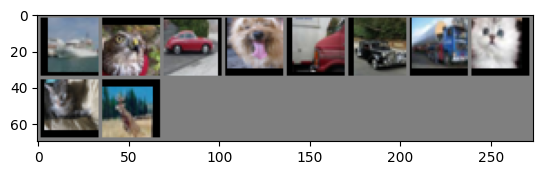

ship bird car dog truck car truck cat cat deer


In [ ]:
# 6. Affichage de quelques images
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:10]))
print(' '.join(f'{classes[labels[j]]}' for j in range(10)))
#


# **Définition du modèle**

In [ ]:
#
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)


ReLU = Rectified Linear Unit qui est  une fonction d’activation non-linéaire: elle garde les valeurs positives, met les négatives à zéro.
FC = Fully Connected = couche complètement connectée: calcule une sortie



Nous créons un réseau CNN qui
prend en entrée des images RGB → 3 canaux.

Produit 32 cartes de caractéristiques (features).

padding=1 conserve les dimensions 32x32.

BatchNorm stabilise les activations.

ReLU ajoute de la non-linéarité.

MaxPool2d(2, 2) réduit de moitié (→ 16x16).

64 canaux, sortie 8x8 après pooling.

128 canaux, sortie 4x4 après pooling.

Aplatit les cartes de 128×4×4 en vecteur de 2048 éléments.

Couche dense (fully connected) : 2048 → 128 neurones avec la fonction ReLU pour non-linéarité.

Une couche dropout qui supprime aléatoirement 50% des neurones pour éviter l’overfitting.

Couche finale : classification dans 10 classes.

Notre réseau suit la logique :  Conv → BN → ReLU → Pool ×3 → Flatten → FC1 → Dropout → FC2

# Configuration de l'entraînement

In [ ]:
# 8. Définition de la fonction de perte, optimiseur, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Nous optons pour la fonction de perte : CrossEntropy (Très éfficace pour la classification supervisée.) et l'optimiseur : Adam  pour sa vitesse de convergence et sa robustesse aux réglages.

#Boucle d'entraînement (Question numéro 4)

📅 Époque [1/100] — Train Loss: 1.2061, Train Acc: 56.30% | Val Loss: 0.9977, Val Acc: 65.11%
📅 Époque [2/100] — Train Loss: 1.1529, Train Acc: 58.26% | Val Loss: 0.9686, Val Acc: 65.46%
📅 Époque [3/100] — Train Loss: 1.1144, Train Acc: 60.31% | Val Loss: 0.9313, Val Acc: 67.07%
📅 Époque [4/100] — Train Loss: 1.0772, Train Acc: 61.42% | Val Loss: 0.9107, Val Acc: 67.93%
📅 Époque [5/100] — Train Loss: 1.0510, Train Acc: 62.38% | Val Loss: 0.8538, Val Acc: 69.41%
📅 Époque [6/100] — Train Loss: 1.0177, Train Acc: 63.59% | Val Loss: 0.8524, Val Acc: 69.39%
📅 Époque [7/100] — Train Loss: 0.9959, Train Acc: 64.45% | Val Loss: 0.8118, Val Acc: 71.02%
📅 Époque [8/100] — Train Loss: 0.9739, Train Acc: 65.66% | Val Loss: 0.8332, Val Acc: 70.42%
📅 Époque [9/100] — Train Loss: 0.9568, Train Acc: 66.34% | Val Loss: 0.8260, Val Acc: 70.76%
📅 Époque [10/100] — Train Loss: 0.9289, Train Acc: 67.23% | Val Loss: 0.7710, Val Acc: 72.70%
📅 Époque [11/100] — Train Loss: 0.9177, Train Acc: 67.93% | Val Loss:

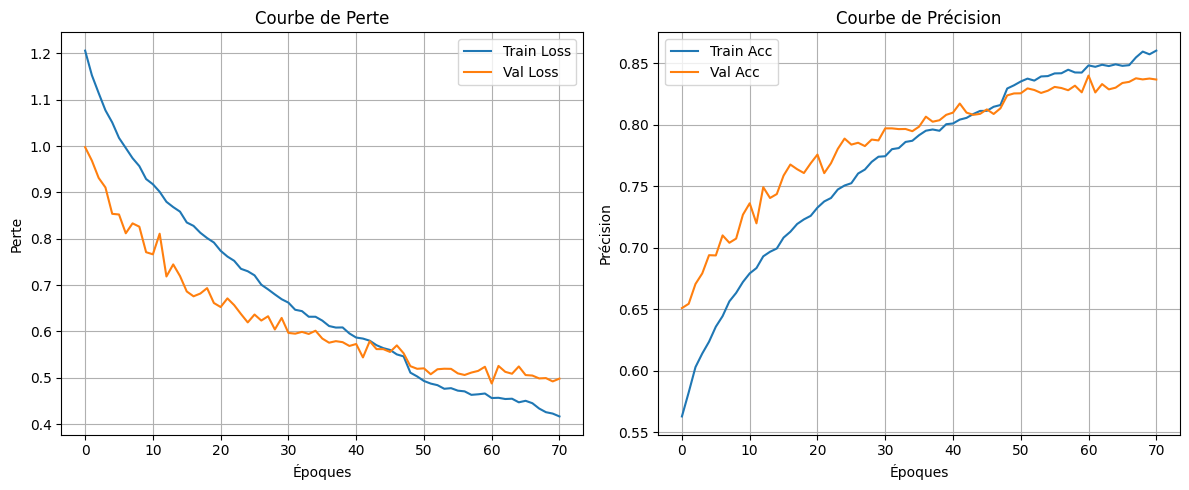

In [ ]:
# 9. Entraînement + Early Stopping
num_epochs = 100
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
patience = 10
early_stop_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(trainloader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Évaluation sur validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(valloader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Époque [{epoch+1}/{num_epochs}] — "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

    scheduler.step(val_loss)

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(" Early stopping déclenché !")
            break

# 10. Courbes
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.title('Courbe de Perte')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.title('Courbe de Précision')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

La perte d'entraînement (Train Loss) et la perte de validation (Val Loss) diminuent de manière stable au fil des époques, ce qui indique que le modèle apprend correctement.

Les deux courbes semblent converger vers une valeur proche de 0.4, ce qui suggère que le modèle a atteint une bonne capacité de généralisation sans surapprentissage (overfitting) évident.

La précision d'entraînement (Train Acc) et la précision de validation (Val Acc) augmentent régulièrement.

Les valeurs finales se stabilisent autour de 0.8 (80%) pour l'entraînement et légèrement en dessous pour la validation.


#Pour connaître la taille (nombre d'images) de CIFAR-10 :

In [ ]:
print(len(trainset))  # nombre d'images d'entraînement
print(len(testset))   # nombre d'images de test


40000
10000


#Evaluation du modèle sur CIFAR-10



In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt

# 11. Évaluation finale sur le test
model.load_state_dict(torch.load("best_model.pth"))  # Charge le meilleur modèle
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcul des métriques
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

#  Affichage des résultats
print(f" Exactitude (accuracy) globale       : {accuracy * 100:.2f}%")
print(f" Précision (macro)       : {precision:.4f}")
print(f" Rappel (macro)          : {recall:.4f}")
print(f" F1-score (macro)        : {f1:.4f}")

# Rapport détaillé par classe
print("\n📊 Rapport de classification complet :")
print(classification_report(all_labels, all_preds, target_names=classes))


 Exactitude (accuracy) globale       : 85.69%
 Précision (macro)       : 0.8566
 Rappel (macro)          : 0.8569
 F1-score (macro)        : 0.8565

📊 Rapport de classification complet :
              precision    recall  f1-score   support

       plane       0.85      0.88      0.86      1000
         car       0.93      0.94      0.93      1000
        bird       0.83      0.76      0.80      1000
         cat       0.73      0.73      0.73      1000
        deer       0.83      0.86      0.84      1000
         dog       0.80      0.77      0.79      1000
        frog       0.89      0.89      0.89      1000
       horse       0.89      0.89      0.89      1000
        ship       0.93      0.92      0.92      1000
       truck       0.90      0.92      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



Exactitude (accuracy) globale : 85.69%
Le modèle classifie correctement 85.69% des échantillons, ce qui est un très bon score

Précision/Rappel/F1-score (macro) ≈ 0.856
Les moyennes macro (non pondérées) des trois métriques sont équilibrées, ce qui indique que le modèle ne sacrifie pas une métrique au profit d'une autre et qu'il n'y a pas de déséquilibre majeur entre classes.

Meilleures performances :

Voiture (car) et Bateau (ship) : F1-score > 0.92

Camion (truck) : F1-score de 0.91

Ces classes sont clairement les mieux reconnues par le modèle.

Performances moyennes :

Avion (plane), Cerf (deer), Grenouille (frog), Cheval (horse) : F1-score entre 0.84 et 0.89

Bonnes performances mais légèrement en dessous des meilleures classes.

Classes les plus difficiles :

Chat (cat) : F1-score de 0.73 (la plus faible)

Chien (dog) : F1-score de 0.79

Oiseau (bird) : F1-score de 0.80

Ces classes animales semblent poser plus de problèmes, probablement en raison de similarités visuelles entre elles.

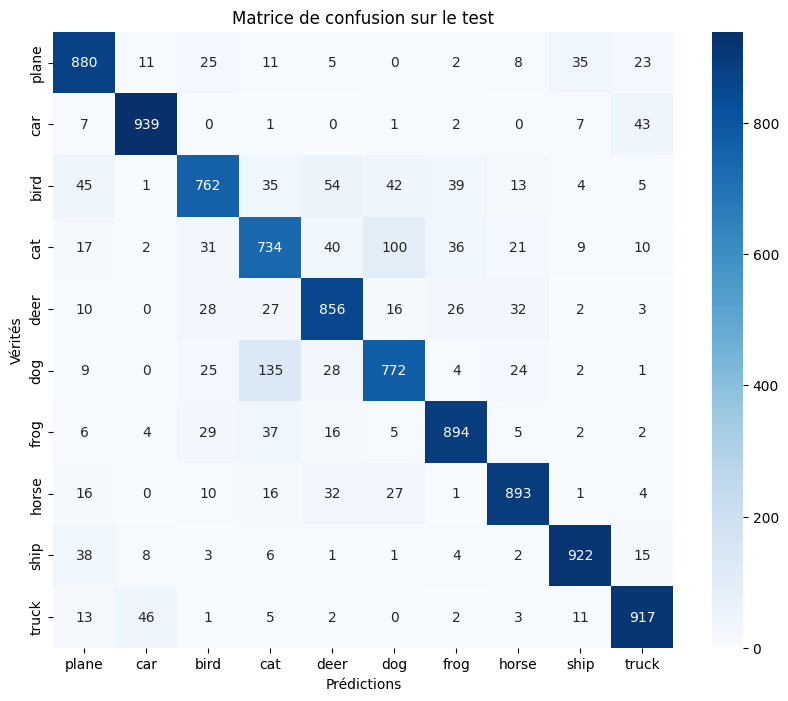

In [ ]:

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Matrice de confusion sur le test")
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.show()


**Analyser**
Précision globale : 85.69% sur les données de test — ce qui est un bon score pour un modèle simple avec augmentation.

L'axe vertical (y) représente les classes réelles.

L'axe horizontal (x) représente les prédictions faites par le modèle.

Ce que la matrice montre :
Les diagonales (ex. : (0,0), (1,1), ..., (9,9)) contiennent les bonnes prédictions.

Les valeurs hors diagonale sont des erreurs de classification.

Bonnes performances sur certaines classes :

Classe 6 (grenouille) : 871 bien classés sur 1000 — très peu de confusion.

Classe 8 (bateau) : 861 bien classés — excellente précision.

Classe 4 (cerf): 803 bien classés — très bon.

 Classes plus confondues (zones à améliorer) :

Classe 3 (probablement chien ou chat) :

161 confondus avec la classe 5.

78 confondus avec la classe 2.

Cela montre que ces classes partagent des traits visuels similaires.

Classe 5 :

Confondue souvent avec classe 3 (154 cas).

Classe 9 :

59 prédits comme classe 1.

28 prédits comme classe 0.

Que cela implique :
Certaines classes visuellement proches (comme chats/chiens ou voitures/camions) sont difficiles à distinguer.

L'augmentation des données a amélioré la robustesse générale, mais des confusions subsistent sur les classes proches.



1. Ajout de la data augmentation
On enrichit les transform_train avec d'autres techniques efficaces :

Le transform_test reste inchangé, car on ne veut pas perturber les données de test :

#**Perform data augmentation to improve performance and compare results.**

## **Entrainement du même modèle mais sans data augmentation**

 Utilisation de : cpu
 Epoch [1/100] — Train Loss: 1.5129, Acc: 43.97% | Val Loss: 1.1184, Acc: 59.39%
 Epoch [2/100] — Train Loss: 1.2020, Acc: 56.74% | Val Loss: 0.9536, Acc: 67.58%
 Epoch [3/100] — Train Loss: 1.0836, Acc: 61.11% | Val Loss: 0.9741, Acc: 64.72%
 Epoch [4/100] — Train Loss: 0.9904, Acc: 64.99% | Val Loss: 0.8363, Acc: 70.52%
 Epoch [5/100] — Train Loss: 0.9331, Acc: 67.05% | Val Loss: 0.7824, Acc: 72.77%
 Epoch [6/100] — Train Loss: 0.8704, Acc: 69.03% | Val Loss: 0.7328, Acc: 74.49%
 Epoch [7/100] — Train Loss: 0.8136, Acc: 71.30% | Val Loss: 0.7630, Acc: 73.21%
 Epoch [8/100] — Train Loss: 0.7720, Acc: 72.68% | Val Loss: 0.6821, Acc: 76.52%
 Epoch [9/100] — Train Loss: 0.7296, Acc: 74.03% | Val Loss: 0.7399, Acc: 75.01%
 Epoch [10/100] — Train Loss: 0.6830, Acc: 75.56% | Val Loss: 0.7758, Acc: 74.86%
 Epoch [11/100] — Train Loss: 0.6543, Acc: 76.51% | Val Loss: 0.6668, Acc: 76.52%
 Epoch [12/100] — Train Loss: 0.6225, Acc: 77.68% | Val Loss: 0.7075, Acc: 76.56%
 Ep

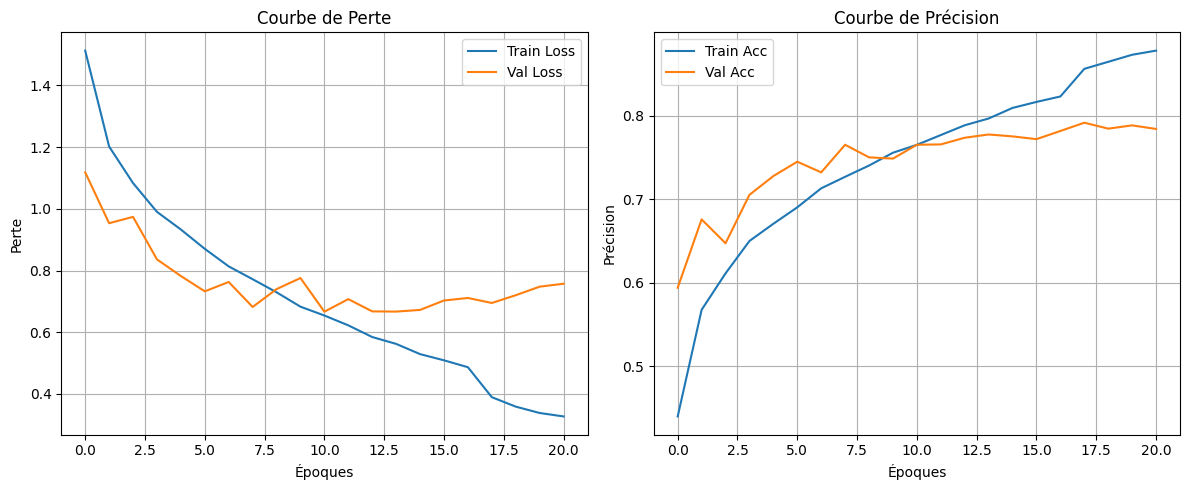


 Résultats SANS Data Augmentation :
 Accuracy       : 0.7666
 Précision      : 0.7706
 Rappel         : 0.7666
 F1-score       : 0.7650

 Rapport de classification :
              precision    recall  f1-score   support

       plane       0.78      0.80      0.79      1000
         car       0.87      0.90      0.88      1000
        bird       0.64      0.68      0.66      1000
         cat       0.67      0.47      0.56      1000
        deer       0.78      0.70      0.74      1000
         dog       0.59      0.77      0.67      1000
        frog       0.78      0.86      0.81      1000
       horse       0.83      0.81      0.82      1000
        ship       0.91      0.83      0.87      1000
       truck       0.85      0.85      0.85      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



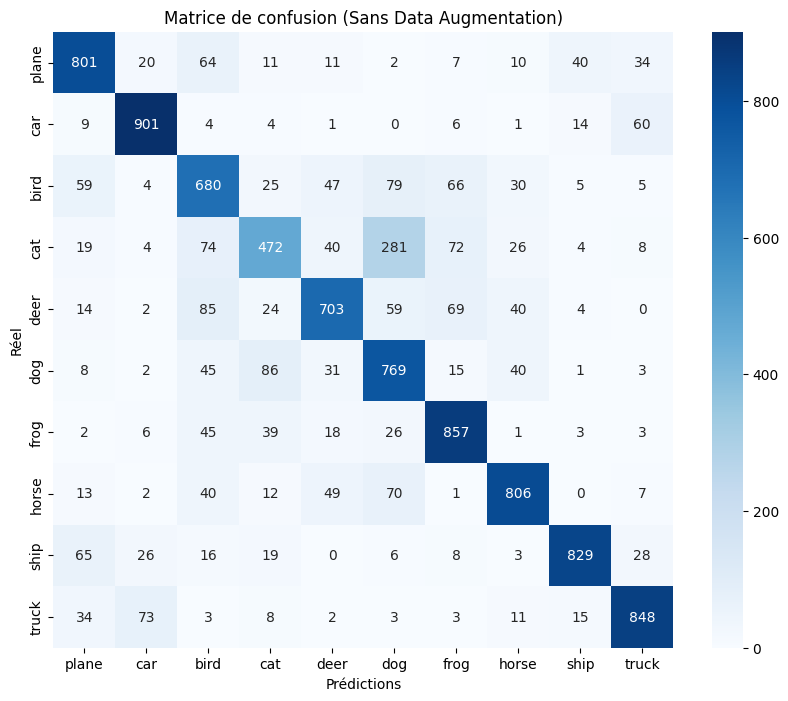

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import seaborn as sns

#  1. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Utilisation de : {device}")

#  2. Transformations SANS data augmentation
transform_basic = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 3. Datasets & split
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_basic)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_basic)

train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

#  4. DataLoaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

#  5. Classes
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#  6. Modèle CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)

#  7. Optimiseur, perte, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

#  8. Entraînement avec early stopping
num_epochs = 100
best_val_loss = float('inf')
patience = 10
early_stop_counter = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(trainloader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(valloader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f" Epoch [{epoch+1}/{num_epochs}] — "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc*100:.2f}%")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model_no_aug.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("⛔️ Early stopping activé")
            break

# 10. Courbes
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.title('Courbe de Perte')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.title('Courbe de Précision')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#  9. Évaluation sur le test
model.load_state_dict(torch.load("best_model_no_aug.pth"))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc_noaug = accuracy_score(all_labels, all_preds)
prec_noaug = precision_score(all_labels, all_preds, average='macro')
recall_noaug = recall_score(all_labels, all_preds, average='macro')
f1_noaug = f1_score(all_labels, all_preds, average='macro')

#  Affichage
print(f"\n Résultats SANS Data Augmentation :")
print(f" Accuracy       : {acc_noaug:.4f}")
print(f" Précision      : {prec_noaug:.4f}")
print(f" Rappel         : {recall_noaug:.4f}")
print(f" F1-score       : {f1_noaug:.4f}")
print("\n Rapport de classification :")
print(classification_report(all_labels, all_preds, target_names=classes))

#  Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Matrice de confusion (Sans Data Augmentation)")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.show()


##1. Analyse Visuelle des Courbes

### **a.  Modèle Avec Data Augmentation :**

**Courbe de perte :**

- Baisse progressive et stable de la loss d’entraînement.

- La perte de validation suit bien celle de l'entraînement jusqu'à la saturation où le earling stopping est déclenché donc le temps a convergé (vers 71 époques).

**Courbe de précision :**

Hausse constante et régulière de la précision, train et validation, jusqu'à atteindre un plateau élevé (~84%-86%).

### **b.   Modèle Sans Data Augmentation (2ᵉ image) :**
**Courbe de perte :**

- Baisse plus rapide de la perte d'entraînement, mais la perte de validation stagne et diverge légèrement, ce qui suggère une tendance de surapprentissage. c'est pourquoi le earling stopping est déclenché plutot pour éviter le surapprentissage (vers 21 epoque)

**Courbe de précision :**

- La précision de validation atteint un plateau plus bas (~78-79%) avec un écart croissant avec celle de l'entraînement

## 2. Comparaison des Performances
Critère---------------Sans Augmentation--------------Avec Augmentation

Accuracy globale-----------76.66%------------------------83.74%

F1-score (macro)-----------0.7650------------------------0.8366

Précision (macro)----------0.7706------------------------0.8368

Rappel (macro)-------------0.7666------------------------0.8374

Early Stopping------------Epoch 21----------------------Epoch 71

Robustesse(gap val/train)-Grand écart (overfitting)----Faible écart(meilleure généralisation)

## 3. Analyse Qualitative par Classe

Classes difficiles (chat, oiseau, chien) :

Modèle Avec augmentation : meilleures performances (+10 points de f1-score parfois).

Modèle Sans augmentation : le modèle confond plus souvent les classes similaires.

## Conclusion

La data augmentation améliore clairement la généralisation du modèle CNN, elle offre :

- une Meilleure robustesse (écart réduit entre train/val).

- des Meilleures performances globales (+7% d'accuracy et de f1-score).

- une Capacité renforcée à distinguer des classes proches ou complexes.

Modèle Sans augmentation :
- Le modèle mémorise trop rapidement les données d'entraînement.

- Généralisation insuffisante sur les données de test (signe classique d’overfitting).



#**QUESTIONS** :

 1. **What are the key components of your CNN architecture?
Les composants clés de mon architecture CNN sont :**

- Convolutional Layers (Conv2d) : 3 couches pour extraire progressivement des caractéristiques locales (bords, textures, formes).

- Batch Normalization (BatchNorm2d) : normalise les activations pour stabiliser et accélérer l’entraînement.

- ReLU Activation : introduit la non-linéarité nécessaire à l'apprentissage de patterns complexes.

- Max Pooling : réduit la taille spatiale tout en conservant les informations importantes.

- Fully Connected Layers (Linear) : transforme les caractéristiques extraites en prédictions de classes.

- Dropout : réduit le surapprentissage en désactivant aléatoirement des neurones lors de l'entraînement.

\\

🔹 2. **How does data augmentation impact performance?**
### La data augmentation améliore nettement la performance en :
- Générant des variations réalistes (flips, crops, rotations) à partir des données d’entraînement.

- Empêchant le surapprentissage sur un dataset trop petit ou trop spécifique.

- Rendant le modèle plus robuste à des images jamais vues ou avec de petites modifications.

**Impact observé :**

- Amélioration des scores (accuracy, précision, rappel, F1-score).

- Meilleure généralisation sur les données de test.

\\

🔹 **3. What are the strengths and weaknesses of using CNN for image classification?**
# Forces :

- Capacité à extraire automatiquement des caractéristiques visuelles complexes.

- Très performant sur des images (textures, objets, visages...).

- Partage des poids (convolutions), ce qui réduit le nombre de paramètres.

- Peut être entraîné de bout en bout, sans feature engineering manuel.

# Faiblesses :

- Nécessite beaucoup de données pour bien généraliser (sauf avec augmentation ou pré-entraînement).

- Consommation de ressources (GPU requis pour entraînement rapide).

- Pas très explicable (black box), difficile d’interpréter ses décisions.

- Sensible à des perturbations visuelles adverses (bruit, transformations inhabituelles).

# **PARTIE 2 : CNN + LSTM**

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
import matplotlib.pyplot as plt

# Pour stocker l'historique
def train_model(model, train_loader, val_loader, epochs=20):
    train_losses, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_acc = evaluate(model, val_loader)
        train_losses.append(running_loss / len(train_loader))
        val_accuracies.append(val_acc)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return train_losses, val_accuracies

# Pour afficher les courbes
def plot_metrics(train_losses, val_accuracies, title=''):
    fig, ax1 = plt.subplots(figsize=(10,5))

    ax1.set_title(f"{title} - Training Loss and Validation Accuracy")
    ax1.plot(train_losses, 'b-', label="Train Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss", color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    ax2.plot(val_accuracies, 'g--', label="Val Accuracy")
    ax2.set_ylabel("Accuracy (%)", color='g')
    ax2.tick_params('y', colors='g')

    fig.tight_layout()
    plt.show()


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# 📁 Chemins vers les fichiers
train_file = '/content/drive/MyDrive/Colab Notebooks/ECG5000/ECG5000_TRAIN.txt'
test_file = '/content/drive/MyDrive/Colab Notebooks/ECG5000/ECG5000_TEST.txt'


In [6]:
import pandas as pd

train_df = pd.read_csv(train_file, sep='\s+', header=None)
test_df = pd.read_csv(test_file, sep='\s+', header=None)

train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1.0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,...,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137
1,1.0,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,...,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250
2,1.0,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,...,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797
3,1.0,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,...,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564
4,1.0,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,...,0.966606,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456


In [7]:
#  Nettoyage : parfois plusieurs espaces → suppression colonnes vides
train_df = train_df.dropna(axis=1, how='all')
test_df = test_df.dropna(axis=1, how='all')

#  Séparation features/labels
X_train = train_df.iloc[:, 1:].values
y_train = train_df.iloc[:, 0].values

X_test = test_df.iloc[:, 1:].values
y_test = test_df.iloc[:, 0].values

In [8]:
#  Normalisation
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#  Reshape pour CNN (batch, channels, length)
X_train = X_train[:, np.newaxis, :]  # (N, 1, L)
X_test = X_test[:, np.newaxis, :]

#  Labels → 0-indexed
y_train = y_train.astype(int) - 1
y_test = y_test.astype(int) - 1

#  Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

#  Split validation
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(
    X_train_tensor, y_train_tensor, test_size=0.2, random_state=42
)

#  DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

## 3. Implémentation du modèle CNN

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class TimeSeriesCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(TimeSeriesCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.AdaptiveAvgPool1d(1)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

## 4. Entraînement et Évaluation du CNN

In [33]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TimeSeriesCNN(num_classes=5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#  Entraînement
def train_model(model, train_loader, val_loader, epochs=20):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_acc = evaluate(model, val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}, Val Acc: {val_acc:.2f}%")

#  Évaluation
def evaluate(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    return 100 * correct / total

#  Lancement
train_model(model, train_loader, val_loader)
test_acc = evaluate(model, test_loader)
print(f"\n Test Accuracy: {test_acc:.2f}%")


Epoch 1/20, Loss: 6.8657, Val Acc: 38.00%
Epoch 2/20, Loss: 3.3569, Val Acc: 38.00%
Epoch 3/20, Loss: 2.7902, Val Acc: 38.00%
Epoch 4/20, Loss: 2.0821, Val Acc: 38.00%
Epoch 5/20, Loss: 2.2840, Val Acc: 55.00%
Epoch 6/20, Loss: 1.7382, Val Acc: 55.00%
Epoch 7/20, Loss: 1.5697, Val Acc: 87.00%
Epoch 8/20, Loss: 1.4411, Val Acc: 84.00%
Epoch 9/20, Loss: 1.5579, Val Acc: 87.00%
Epoch 10/20, Loss: 1.2800, Val Acc: 87.00%
Epoch 11/20, Loss: 1.7102, Val Acc: 86.00%
Epoch 12/20, Loss: 1.3398, Val Acc: 84.00%
Epoch 13/20, Loss: 1.3335, Val Acc: 85.00%
Epoch 14/20, Loss: 1.1224, Val Acc: 88.00%
Epoch 15/20, Loss: 1.3076, Val Acc: 88.00%
Epoch 16/20, Loss: 1.0463, Val Acc: 85.00%
Epoch 17/20, Loss: 1.0358, Val Acc: 88.00%
Epoch 18/20, Loss: 0.9828, Val Acc: 87.00%
Epoch 19/20, Loss: 0.8579, Val Acc: 88.00%
Epoch 20/20, Loss: 0.7975, Val Acc: 90.00%

 Test Accuracy: 93.00%


In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Nouvelle fonction d'évaluation avec toutes les métriques
def evaluate_full(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"\n Accuracy:  {acc:.4f}")
    print(f" Precision: {prec:.4f}")
    print(f" Recall:    {rec:.4f}")
    print(f" F1 Score:  {f1:.4f}")


#le test set pour CNN
print("\n Test Set Evaluation (CNN):")

evaluate_full(model, test_loader)


 Test Set Evaluation (CNN):

 Accuracy:  0.9300
 Precision: 0.9225
 Recall:    0.9300
 F1 Score:  0.9176


## **Implémentation du modèle CNN-LSTM**

In [11]:
class CNN_LSTM(nn.Module):
    def __init__(self, num_classes=5):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)

        self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True)

        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: [batch, 1, sequence_length]
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))  # [batch, 64, L]
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))  # [batch, 128, L/4]

        x = x.permute(0, 2, 1)  # [batch, sequence, features] pour LSTM
        output, (hn, cn) = self.lstm(x)  # output: [batch, seq, hidden]
        x = hn[-1]  # Dernier état caché
        x = self.fc(x)
        return x


## **Entraînement du modèle CNN-LSTM**

In [12]:
model_hybrid = CNN_LSTM(num_classes=5).to(device)

optimizer = optim.Adam(model_hybrid.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

#  Entraînement
train_model(model_hybrid, train_loader, val_loader)

#  Évaluation sur le test set
test_acc_hybrid = evaluate(model_hybrid, test_loader)
print(f"\n Test Accuracy (CNN-LSTM): {test_acc_hybrid:.2f}%")


Epoch 1/20, Loss: 8.5491, Val Acc: 83.00%
Epoch 2/20, Loss: 4.3006, Val Acc: 87.00%
Epoch 3/20, Loss: 2.4681, Val Acc: 89.00%
Epoch 4/20, Loss: 1.8958, Val Acc: 89.00%
Epoch 5/20, Loss: 1.6536, Val Acc: 89.00%
Epoch 6/20, Loss: 1.7978, Val Acc: 88.00%
Epoch 7/20, Loss: 1.4821, Val Acc: 88.00%
Epoch 8/20, Loss: 1.3762, Val Acc: 89.00%
Epoch 9/20, Loss: 1.7404, Val Acc: 88.00%
Epoch 10/20, Loss: 1.2175, Val Acc: 89.00%
Epoch 11/20, Loss: 1.1561, Val Acc: 89.00%
Epoch 12/20, Loss: 1.0874, Val Acc: 89.00%
Epoch 13/20, Loss: 1.0015, Val Acc: 89.00%
Epoch 14/20, Loss: 0.9449, Val Acc: 90.00%
Epoch 15/20, Loss: 0.9224, Val Acc: 89.00%
Epoch 16/20, Loss: 0.9054, Val Acc: 90.00%
Epoch 17/20, Loss: 0.8473, Val Acc: 91.00%
Epoch 18/20, Loss: 0.8383, Val Acc: 91.00%
Epoch 19/20, Loss: 0.9747, Val Acc: 92.00%
Epoch 20/20, Loss: 0.7762, Val Acc: 92.00%

 Test Accuracy (CNN-LSTM): 93.56%


In [29]:
# Exemple d'utilisation sur le test set pour CNN+LSTM
print("\n Test Set Evaluation (CNN+LSTM):")
evaluate_full(model_hybrid, test_loader)


 Test Set Evaluation (CNN+LSTM):

 Accuracy:  0.9356
 Precision: 0.9262
 Recall:    0.9356
 F1 Score:  0.9212


**Accuracy**

 CNN+LSTM est légèrement meilleur (0.9356 vs 0.9300).

Cela montre que la modélisation temporelle par LSTM apporte un petit gain en précision globale.

**Precision & Recall**
Recall plus élevé avec CNN+LSTM → le modèle rate moins de vrais positifs.

Precision aussi légèrement meilleure → moins de faux positifs.

Cela suggère que CNN+LSTM est plus équilibré pour la détection des bonnes classes, surtout dans des cas plus subtils.

**F1 Score**

Le F1 score, qui combine précision et rappel, est aussi légèrement meilleur pour CNN+LSTM.

Ce gain indique une meilleure balance entre erreurs.

## Interprétation
Bien que le CNN seul soit déjà performant dont 93%, l’ajout du LSTM améliore la modélisation des dépendances temporelles entre les motifs extraits par les convolutions. Cela permet au modèle d’avoir une compréhension plus globale de la séquence, ce qui est bénéfique, même pour un dataset comme ECG5000 où nous avons rémarqué que les motifs sont principalement locaux.

## Conclusion
Le modèle hybride CNN+LSTM est globalement supérieur, bien que le gain soit modeste. Il capture mieux les dépendances temporelles, ce qui est utile même dans des tâches de classification de formes temporelles simples.

##**QUESTION 1.**

How does CNN perform compared to CNN-LSTM for time series classification?

Résultats obtenus :

Modèle---------------Accuracy----------Precision-------------Recall----------F1-score

CNN------------------93.00 %------------92.25 %----------93.00 %----------91.76 %

CNN+LSTM-------------93.56 %------------92.62 %----------93.56 %----------92.12 %

CNN-LSTM est légèrement meilleur que le CNN seul.

La question se pose pourquoi ?
Le CNN est bon pour extraire des motifs locaux (changements de forme, segments caractéristiques du signal ECG).

mais Le CNN-LSTM combine :

des filtres CNN qui capturent la structure spatiale du signal,

avec un LSTM qui modélise les relations temporelles entre ces motifs.

Résultat : le CNN-LSTM comprend à la fois la forme des signaux et leur évolution dans le temps, ce qui améliore légèrement la performance.

##**QUESTION 2**

Why is LSTM beneficial for time-dependent data?

Le LSTM (Long Short-Term Memory) est une forme avancée de RNN conçue pour apprendre les dépendances temporelles, c’est-à-dire La relation entre un événement passé et un événement futur.

Par exemple, dans un signal ECG, une onde R peut influencer ce qui suit plusieurs instants plus tard.

##**QUESTION 3**

How do hyperparameter changes affect model performance?

Nous avons tester différents changement des hyperparametres (5 au total testés) notamment : le **learning rate**, le **batch size**, changer le **nombre de couche CNN**, le nombre de **couches cachées** avec LSTM, **nombre d'époques**. après différents changement voici les observations qui suivent :

**1. learning rate**

- Avec un petit Lr : On a eu un apprentissage lent.

- Avec un Lr très grand : On a observé une instabilité, le modèle sautille au lieu de converger.

Nous avons opté d'utiliser 0.001, ce qui a été un bon compromis.

**2. Taille du batch**

- Avec un petit batch (32) : plus de bruit, mais meilleure généralisation.

- Avec un Grand batch (128) : plus rapide, mais parfois sur-apprentissage.

Nous avons opté d'utiliser 64, ce qui est un bon compromis.

**3. Nombre de couches CNN / filtres**

Avec Trop peu : nous avons observé que le modèle n’apprend pas assez de motifs.

Avec Trop de filtre : risque de sur-apprentissage, surtout que nous avons un dataset petit.

Nous avons choisi un modèle avec 3 couches CNN avec des filtres croissants : 64 → 128 → 256

**4. LSTM : nombre de neurones cachés et couches**

Avec Trop peu de couche cachées : Nous avons observé que le modèle ne capture pas bien la dépendance temporelle.

Avec Trop de couche cachées : Le modèle était plus long à entraîner.

Nous avons choisi un hidden_size=64

**5. Nombre d’époques (epochs)**

Avec Trop peu d'epoques : le modèle n’a pas le temps d’apprendre.

Avec Trop d'époques  : rique de overfitting.
